In [1]:
#importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import datasets, metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

### Model 7:

Model will evaluate impact on Sale Price of:
- Overall Condition
- Overall Quality
- Interaction Condition and Quality (feature engineering)
- Bathrooms
- Bedrooms
- Total sqft Lot Area (feature engineering; log-transform based on skew)
- Price per Sqft (per neighborhood)

### Feature Engineering

**Price per Sqft**

Assumption: 
- Sale Price of a house is impacted by the price in the neighborhood (for future models, this would be adjusted to be calculated off of the most recent year)
- To accommodate for any outliers, I use Median Sale Price by Neighborhood
- To proxy the price/sqft (which would help normalize price across different property types), I use total sqft by neighborhood
- The final calculation is the Median Sale Price / Total Sqft in each neighborhood

In [2]:
# Median sale price/avg sqft by neighborhood
%store -r df_no_na
hood_bldg_comb = df_no_na.groupby(['Neighborhood'], as_index=False).aggregate(
    {"SalePrice": "median", "Total_SF": "mean"}).reset_index().sort_values(by=["Neighborhood"],ascending=True)
hood_bldg_comb.head(2)


,index,Neighborhood,SalePrice,Total_SF
0,0,Blmngtn,192250.0,3245.318182
1,1,Blueste,137500.0,2463.000000


In [4]:
hood_bldg_comb["Price_per_SF"] = hood_bldg_comb["SalePrice"]/hood_bldg_comb["Total_SF"]

<br>

**Total Sqft (from Models 2 and 3)**

In [21]:
df_no_na["Total_SF"] = df_no_na[["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area"]].sum(axis=1) 

In [22]:
df_test_no_na["Total_SF"] = df_test_no_na[["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area"]].sum(axis=1) 

<br>

**Bathrooms (from Model 5)**

In [19]:
df_no_na["Bathrooms"] = df_no_na["Full Bath"] + df_no_na["Bsmt Half Bath"] + df_no_na["Bsmt Full Bath"] + df_no_na["Half Bath"]

In [20]:
df_test_no_na["Bathrooms"] = df_test_no_na["Full Bath"] + df_test_no_na["Bsmt Half Bath"] + df_test_no_na["Bsmt Full Bath"] + df_test_no_na["Half Bath"]

<br>

**Interaction of Quality/Condition (from Models 2 and 3)**

In [17]:
df_no_na["Qual_cond"] = df_no_na["Overall Qual"] * df_no_na["Overall Cond"]

In [18]:
df_test_no_na["Qual_cond"] = df_test_no_na["Overall Qual"] * df_test_no_na["Overall Cond"]

In [6]:
neighborhood_dict = {'MeadowV': "Meadow Village", 
                     'IDOTRR':"Iowa DOT and Rail Road", 
                     'BrDale':"Briardale", 
                     'OldTown':"Old Town", 
                     'Edwards':"Edwards", 
                     'BrkSide':"Brookside",
                     'Sawyer':"Sawyer",
                     'SWISU':"South & West of Iowa State University", 
                     'Landmrk':"Landmark",
                     'Blueste':"Bluestem", 
                     'NAmes':"North Ames", 
                     'NPkVill':"Northpark Villa", 
                     'Mitchel':"Mitchell",
                     'Gilbert':"Gilbert", 
                     'SawyerW':"Sawyer West", 
                     'NWAmes':"Northwest Ames", 
                     'Greens':"Greens", 
                     'Blmngtn':"Bloomington Heights", 
                     'Crawfor':"Crawford",
                     'CollgCr':"College Creek", 
                     'Timber':"Timberland", 
                     'Somerst':"Somerset", 
                     'ClearCr':"Clear Creek", 
                     'Veenker':"Veenker", 
                     'GrnHill':"Green Hills",
                     'NoRidge':"Northridge", 
                     'NridgHt':"Northridge Heights", 
                     'StoneBr':"Stone Brook"}

In [65]:
index_for_join = hood_bldg_comb[['Neighborhood',"Price_per_SF"]]
index_for_join.sort_values(by="Price_per_SF", ascending= False)
#index_for_join["Neighborhood"]=index_for_join["Neighborhood"].map(neighborhood_dict)

,Neighborhood,Price_per_SF
10,GrnHill,114.355728
25,StoneBr,77.774745
19,NridgHt,73.307456
27,Veenker,67.758156
24,Somerst,66.389890
18,NoRidge,65.607446
4,ClearCr,64.831119
9,Greens,64.713896
6,Crawfor,62.891281
5,CollgCr,61.923445


In [8]:
count_of_sales = df_no_na.groupby(['Neighborhood'])["SalePrice"].aggregate(["count"]).reset_index()
#count_of_sales["Neighborhood"]=count_of_sales["Neighborhood"].map(neighborhood_dict)
count_of_sales

,Neighborhood,count
0,Blmngtn,22
1,Blueste,6
2,BrDale,19
3,BrkSide,75
4,ClearCr,27
5,CollgCr,180
6,Crawfor,71
7,Edwards,143
8,Gilbert,116
9,Greens,3


In [66]:
count_of_sales_area = pd.merge(index_for_join,count_of_sales, on = "Neighborhood", how="left")
sorted_count_of_sales = count_of_sales_area.sort_values(by="Price_per_SF")
sorted_count_of_sales

,Neighborhood,Price_per_SF,count
13,MeadowV,46.293476,24
20,OldTown,46.496260,163
11,IDOTRR,47.366760,68
7,Edwards,48.697097,143
15,NAmes,51.489497,310
21,SWISU,52.238949,32
17,NWAmes,52.783991,87
14,Mitchel,53.631358,82
22,Sawyer,53.879427,111
3,BrkSide,54.128420,75


In [53]:
area_group = df_no_na.groupby('Neighborhood')["SalePrice"].describe()[["count","mean"]].reset_index()
format_map = {'count':'{:}','mean':'${0:,.0f}'}
def color_count(val):
    color = "#f6d6d6" if "count"<20 else 'white'
    return f'background-color: {color}'
area_group.sort_values(by="mean", ascending=False).style.format(format_map).hide(axis="index")
#display(area_group.style.applymap(color_count, subset=['count']))

Neighborhood,count,mean
StoneBr,38.0,"$329,676"
NridgHt,122.0,"$322,831"
NoRidge,48.0,"$316,294"
GrnHill,2.0,"$280,000"
Veenker,17.0,"$253,571"
Timber,48.0,"$241,051"
Somerst,130.0,"$227,184"
ClearCr,27.0,"$217,490"
Crawfor,71.0,"$205,901"
CollgCr,180.0,"$202,497"


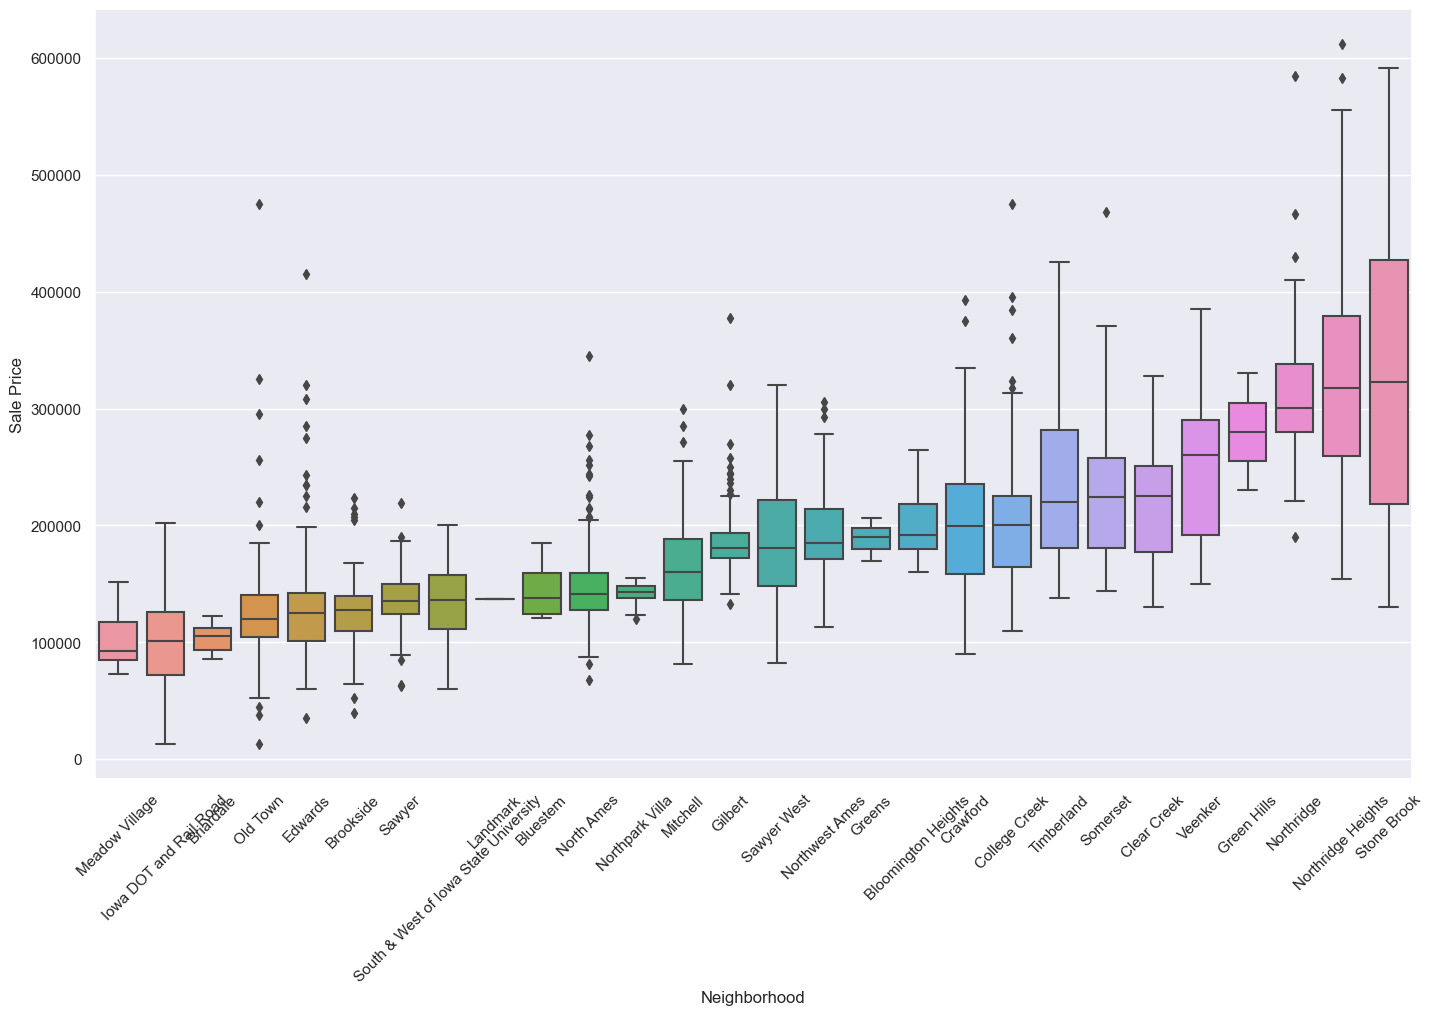

In [1450]:
plt.figure(figsize=(17,10))
order = df_no_na.groupby(["Neighborhood"])["SalePrice"].aggregate(["median"]).sort_values(by="median").index #iteration on a code from Stack Overflow user zkytony
area = sns.boxplot(x='Neighborhood', y='SalePrice', data=df_no_na, order = order)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
area.set_xticklabels(area.get_xticklabels(),rotation=45);

In [55]:
zone_group = df_no_na.groupby('MS Zoning')["SalePrice"].describe()[["count","mean"]].reset_index()
format_map = {'count':'{:}','mean':'${0:,.0f}'}
def color_count(val):
    color = "#f6d6d6" if "count"<20 else 'white'
    return f'background-color: {color}'
zone_group.sort_values(by="mean", ascending=False).style.format(format_map).hide(axis="index")
#display(area_group.style.applymap(color_count, subset=['count']))

MS Zoning,count,mean
FV,101.0,"$218,618"
RL,1598.0,"$191,235"
RH,14.0,"$148,860"
RM,314.0,"$129,209"
C (all),19.0,"$78,011"
I (all),1.0,"$57,625"
A (agr),2.0,"$47,300"


/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_20812/1534010636.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df_no_na.groupby(["MS Zoning"]).median()["SalePrice"].sort_values().index #iteration on a code from Stack Overflow user zkytony


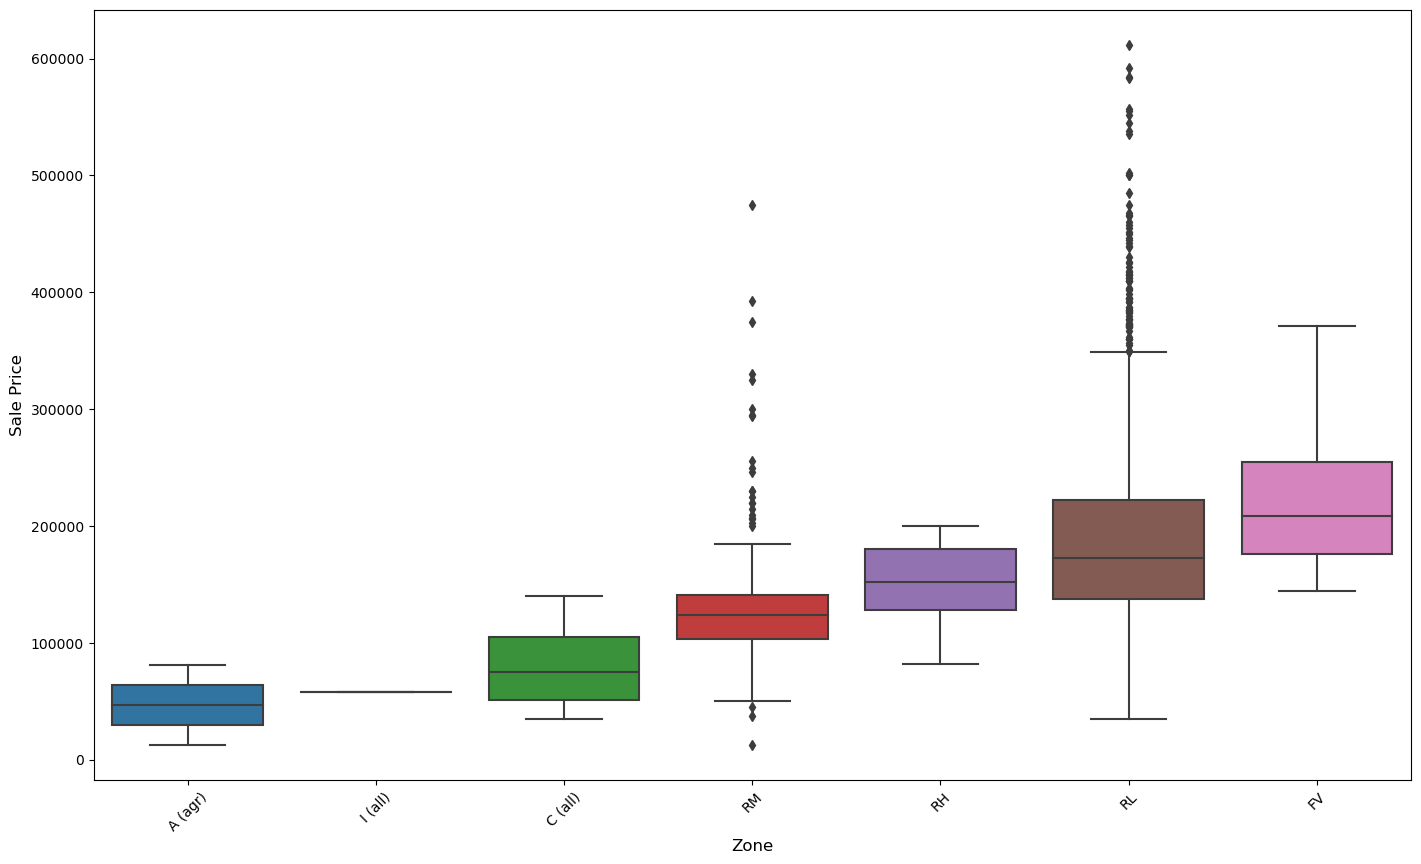

In [56]:
plt.figure(figsize=(17,10))
order = df_no_na.groupby(["MS Zoning"]).median()["SalePrice"].sort_values().index #iteration on a code from Stack Overflow user zkytony
area = sns.boxplot(x='MS Zoning', y='SalePrice', data=df_no_na, order = order)
plt.xlabel('Zone', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
area.set_xticklabels(area.get_xticklabels(), rotation=45);

In [157]:
hood_bldg_comb = df_no_na.groupby(['Neighborhood', "Bldg Type"], as_index=False)["SalePrice"].aggregate(
    ["median","count"]).reset_index().sort_values(by=["Neighborhood"],ascending=True)

In [165]:
def str_join(hood_bldg_comb, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep),
                      [hood_bldg_comb[col] for col in cols])

hood_bldg_comb["Neighborhood_Type"]=str_join(hood_bldg_comb, '_', 'Neighborhood', 'Bldg Type')
hood_bldg_comb.head(2)

,Neighborhood,Bldg Type,median,count,Neighborhood_Type
0,Blmngtn,1Fam,185485.0,3,Blmngtn_1Fam
1,Blmngtn,TwnhsE,194201.0,19,Blmngtn_TwnhsE


In [122]:
hood_median = df_no_na.groupby(['Neighborhood'])["SalePrice"].aggregate(
    ["mean","median","count"]).reset_index().sort_values(by=["Neighborhood"],ascending=True)
hood_median.head(2)

,Neighborhood,mean,median,count
0,Blmngtn,200417.681818,192250.0,22
1,Blueste,144566.666667,137500.0,6


In [156]:
hood_bldg = df_no_na.groupby(['Neighborhood'])["Bldg Type"].value_counts(normalize=True).to_frame('pct').reset_index()

In [155]:
def str_join(hood_bldg, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep),
                      [hood_bldg[col] for col in cols])

hood_bldg["Neighborhood_Type"]=str_join(hood_bldg, '_', 'Neighborhood', 'Bldg Type')
hood_bldg.head(2)

,Neighborhood,Bldg Type,pct,Neighborhood_Type
0,Blmngtn,TwnhsE,0.863636,Blmngtn_TwnhsE
1,Blmngtn,1Fam,0.136364,Blmngtn_1Fam


In [167]:
#hood_bldg_comb.merge(hood_bldg[['Neighborhood_Type', 'pct']])

df4 = pd.merge(hood_bldg_comb, hood_bldg, how='left', on=['Neighborhood','Bldg Type'], suffixes=['', '_'])
cols = ['Neighborhood', 'Bldg Type', 'Neighborhood_Type', 'pct', 'median', 'count']
df4 = df4[cols]
df4.head()

,Neighborhood,Bldg Type,Neighborhood_Type,pct,median,count
0,Blmngtn,1Fam,Blmngtn_1Fam,0.136364,185485.0,3
1,Blmngtn,TwnhsE,Blmngtn_TwnhsE,0.863636,194201.0,19
2,Blueste,Twnhs,Blueste_Twnhs,0.500000,123900.0,3
3,Blueste,TwnhsE,Blueste_TwnhsE,0.500000,162500.0,3
4,BrDale,Twnhs,BrDale_Twnhs,0.842105,104700.0,16


In [180]:
df3 = df_no_na["Bldg Type"].value_counts(normalize=True).to_dict()
df3
#1Fam	Single-family Detached	
#2FmCon	Two-family Conversion; originally built as one-family dwelling
#Duplx	Duplex
#TwnhsE	Townhouse End Unit
#TwnhsI	Townhouse Inside Unit

{'1Fam': 0.828696925329429,
 'TwnhsE': 0.07857491459248414,
 'Duplex': 0.036603221083455345,
 'Twnhs': 0.03367496339677892,
 '2fmCon': 0.02244997559785261}

In [178]:
df4['pct_overall'] = df4["Bldg Type"].map(df3)
df4['pct_compare']= (df4['pct'] >= df4['pct_overall']).astype(int)

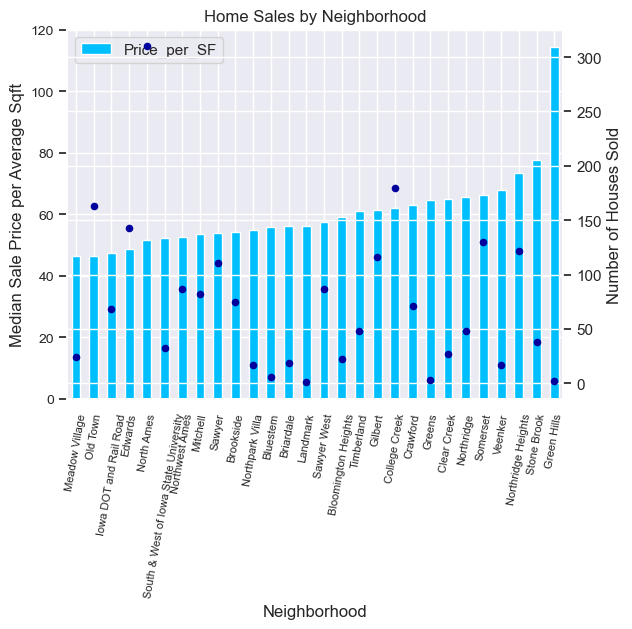

In [1496]:
fig, ax = plt.subplots()

# plot bar chart on the first subplot
sorted_count_of_sales.plot(kind='bar', x='Neighborhood', y='Price_per_SF', ax=ax, color = "#00BFFF")

# create second subplot with shared x-axis
ax2 = ax.twinx()

# plot line chart on the second subplot
sorted_count_of_sales.plot(kind='scatter', x='Neighborhood', y='count', ax=ax2, color='#00009C')

# set axis labels and title
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Median Sale Price per Average Sqft')
ax2.set_ylabel('Number of Houses Sold')
ax.set_title('Home Sales by Neighborhood')
ax.tick_params(axis='x', labelsize=8, rotation=80)
ax.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)

plt.show()

In [1498]:
count_of_sales_area["count"].mean()

73.17857142857143

In [67]:
joined_df = pd.merge(df_no_na,index_for_join, on = "Neighborhood", how="left")
%store joined_df

Stored 'joined_df' (DataFrame)


In [70]:
#repeat for test data (we will use the same price per sq by neighborhood in test data)
%store -r df_test_no_na
joined_test_df = pd.merge(df_test_no_na,index_for_join, on = "Neighborhood", how="left")
%store joined_test_df

Stored 'joined_test_df' (DataFrame)


In [71]:
df_no_na_model7 = joined_df[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Lot Area",
                         "SalePrice",
                           "Price_per_SF" ]]

In [72]:
#repeat for test data
df_test_no_na_model7 = joined_test_df[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Lot Area",
                           "Price_per_SF"]]

<br>

**Lot Area (log transform)**

In [73]:
df_no_na_model7["Transform_Lot_Area"] = np.log10(df_no_na_model7["Lot Area"])

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_71178/4236539525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_model7["Transform_Lot_Area"] = np.log10(df_no_na_model7["Lot Area"])


In [74]:
#repeat for test data
df_test_no_na_model7["Transform_Lot_Area"] = np.log10(df_test_no_na_model7["Lot Area"])

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_71178/1753974240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_model7["Transform_Lot_Area"] = np.log10(df_test_no_na_model7["Lot Area"])


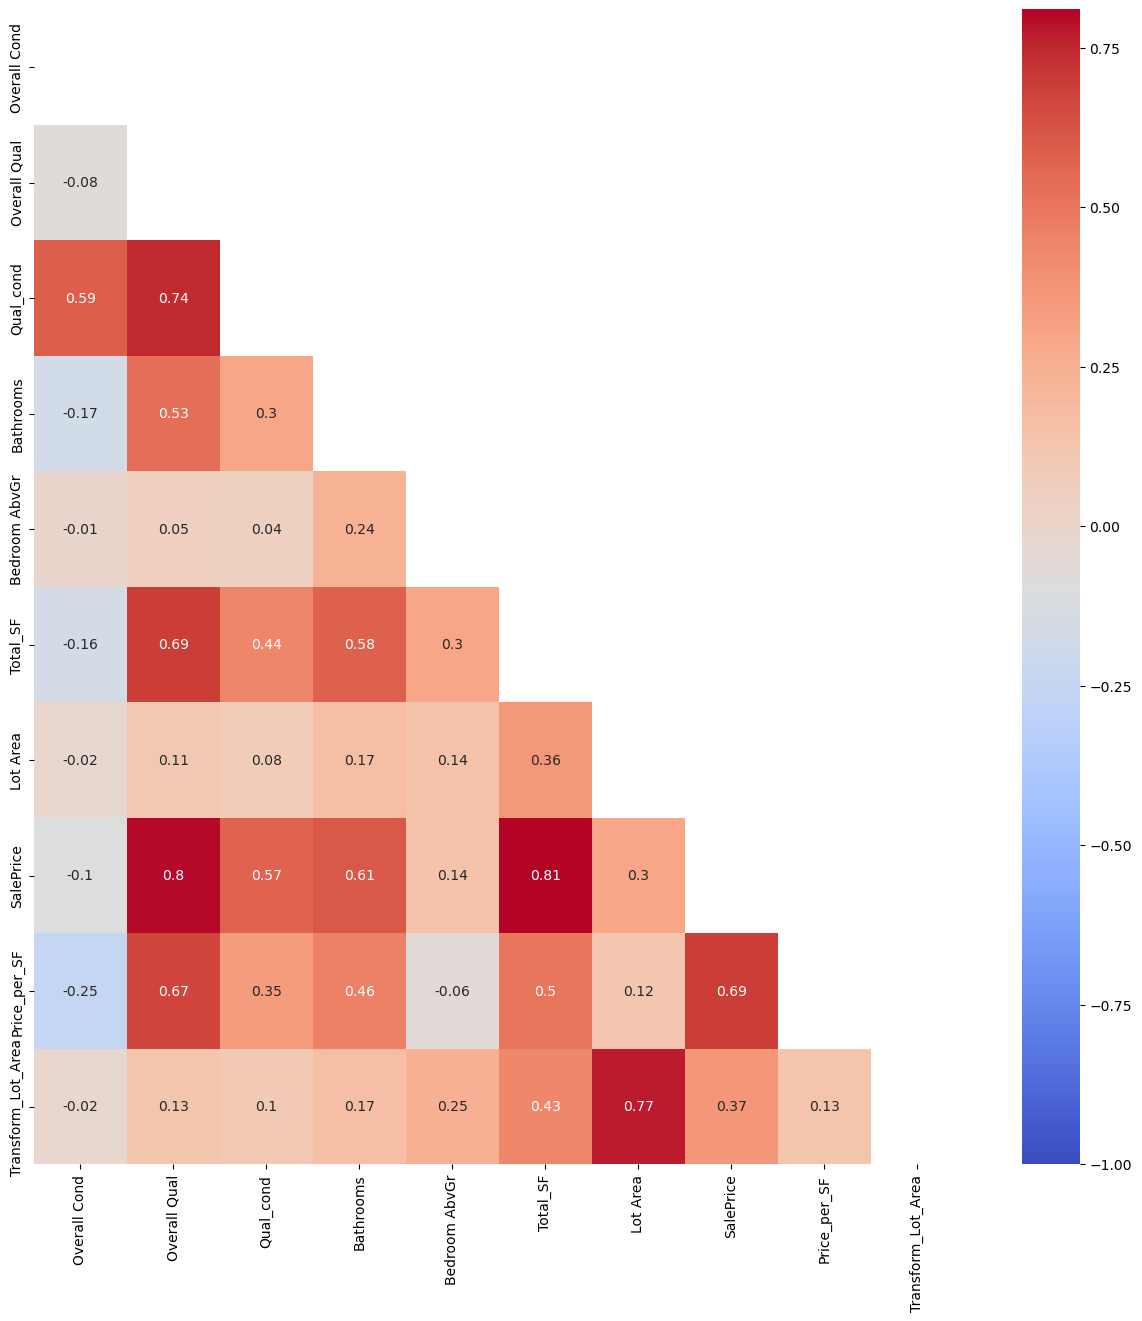

In [872]:
fig, ax = plt.subplots(figsize = (15,15))
mask = np.triu(np.ones_like(df_no_na_model7.corr(), dtype=bool))
sns.heatmap(round(df_no_na_model7.corr(),2), annot=True, mask = mask, cmap="coolwarm", vmin=-1);

**NAs are removed post transformation**

In [75]:
df_no_na_model7.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_71178/1174364692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_model7.dropna(how = "any", inplace = True)


In [76]:
#repeat for test data
df_test_no_na_model7.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_71178/1195795637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_model7.dropna(how = "any", inplace = True)


### Model - Linear Regression

In [77]:
X7 = df_no_na_model7[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Transform_Lot_Area",
                           "Price_per_SF"]]
y7 = df_no_na_model7["SalePrice"]

In [78]:
X7_for_test = df_test_no_na_model7[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Transform_Lot_Area",
                           "Price_per_SF"]]

In [79]:
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, random_state=42)

In [80]:
ss = StandardScaler()
#ss.fit(X_train)
X7_train = ss.fit_transform(X7_train)
X7_test = ss.transform(X7_test)

In [81]:
lr7 = LinearRegression()

In [82]:
lr7.fit(X7_train,y7_train)

LinearRegression()

In [83]:
y_7_pred = lr7.predict(X7_test) #validate model

In [84]:
rmse_7 = np.sqrt(mean_squared_error(y7_test, y_7_pred))

In [85]:
print("R2 training data:", round(lr7.score(X7_train, y7_train), 2))
print("R2 test data:", round(lr7.score(X7_test, y7_test), 2))
print(f"root mean squared error: {rmse_7}.")

R2 training data: 0.82
R2 test data: 0.84
root mean squared error: 30908.878066191566.


In [86]:
X_7_test_pred = X7_for_test.values

In [90]:
%store -r df_test
submission7 = pd.DataFrame(df_test, columns=["Id"])
submission7["SalePrice"] = lr7.predict(X_7_test_pred)

In [92]:
submission7.to_csv('./datasets/submission7.csv', index=False)

### Model Validation

In [43]:
lasso_7 = Lasso(alpha=1)
lasso_7.fit(X7_train, y7_train)

Lasso(alpha=1)

In [48]:
print('R2 training data', round(lasso_7.score(X7_train, y7_train), 2))
print('R2 test data', round(lasso_7.score(X7_test, y7_test), 2))

R2 training data 0.67
R2 test data 0.58


In [49]:
pred_train7 = lasso_7.predict(X7_train)
mse_train7 = mean_squared_error(y7_train, pred_train7)
print('RMSE training data', round(mse_train7**0.5, 2))

# Test data
pred7 = lasso_7.predict(X7_test)
mse_test7 = mean_squared_error(y7_test, pred7)
print('RMSE test data', round(mse_test7**0.5, 2))

RMSE training data 29922.23
RMSE test data 33206.17


In [44]:
model_lasso_7 = LassoCV(cv=5, random_state=0, max_iter=10000)
model_lasso_7.fit(X7_train, y7_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [45]:
model_lasso_7.alpha_

36.104001606333924

In [46]:
lasso_7_best = Lasso(alpha=model_lasso_7.alpha_)
lasso_7_best.fit(X7_train, y7_train)

Lasso(alpha=36.104001606333924)

In [47]:
print('R2 training data', round(lasso_7_best.score(X7_train, y7_train), 2))
print('R2 test data', round(lasso_7_best.score(X7_test, y7_test), 2))
pred_train7_best = lasso_7_best.predict(X7_train)
mse_train7_best = mean_squared_error(y7_train, pred_train7_best)
print('RMSE training data', round(mse_train7_best**0.5, 2))

# Test data
pred7_best = lasso_7_best.predict(X7_test)
mse_test7_best = mean_squared_error(y7_test, pred7_best)
print('RMSE test data', round(mse_test7_best**0.5, 2))

R2 training data 0.67
R2 test data 0.58
RMSE training data 29922.93
RMSE test data 33204.06


In [51]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

ridge_scores = cross_val_score(ridge, X7_train, y7_train, cv = 3)
ridge_scores.mean()

0.6133478129670452

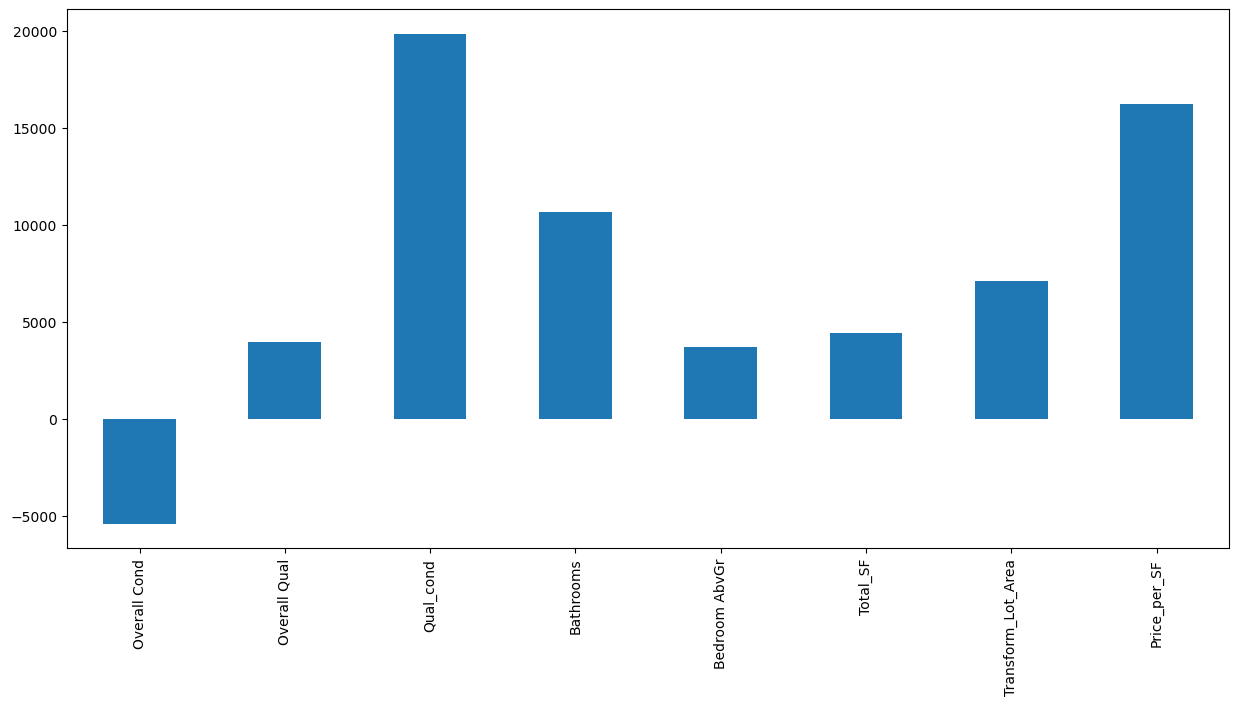

In [55]:
pd.Series(lasso_7_best.coef_, index=X7.columns).plot.bar(figsize = (15, 7));